# 📚 import libraries

In [123]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# 🔍 ETL (Extract - Transfer - Load)

In [68]:
dataset_folder = "dataset/Grapevine_Leaves_Image_Dataset"
class_samples = {}

for class_name in os.listdir(dataset_folder):
    class_folder = os.path.join(dataset_folder, class_name)
    
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        
        if class_name not in class_samples:
            image = cv2.imread(image_path)
            class_samples[class_name] = image
            break

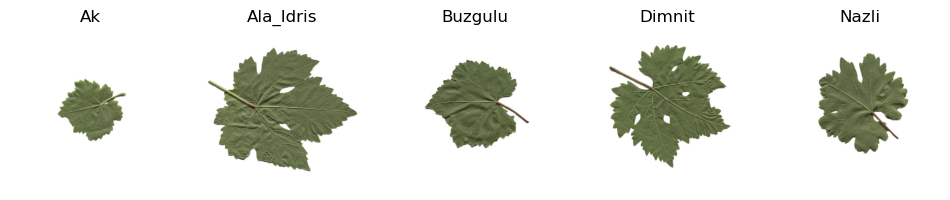

In [69]:
# Plot one sample image from each class
plt.figure(figsize=(12, 6))
for i, (class_name, sample_image) in enumerate(class_samples.items()):
    plt.subplot(1, len(class_samples), i + 1)
    plt.title(class_name)
    plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.show()

In [70]:
BATCH_SIZE = 20
TARGET_SIZE = (300, 300)
NUM_CLASSES = 5
EPOCHS = 100
datagen = ImageDataGenerator(
    rescale=1./255,
    
)

In [71]:
images = []
labels = []

for class_name in os.listdir(dataset_folder):
    class_folder = os.path.join(dataset_folder, class_name)

    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)

        img = load_img(image_path, target_size=TARGET_SIZE)
        img = img_to_array(img)
        img = datagen.random_transform(img)

        images.append(img)
        labels.append(class_name)

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [72]:
images.shape

(500, 300, 300, 3)

In [73]:
# Convert string labels to numerical labels
class_to_index = {
   'Ak': 0,
   'Ala_Idris': 1,
   'Buzgulu': 2,
   'Dimnit': 3,
   'Nazli': 4
}
numerical_labels = [class_to_index[label] for label in labels]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(images, numerical_labels, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [76]:
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [78]:
X_train.shape, X_val.shape, X_test.shape

((320, 300, 300, 3), (80, 300, 300, 3), (100, 300, 300, 3))

# 🏗️ Baseline model `without` Data Augmentation

### Model architecture

In [80]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [81]:
model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)      

In [86]:
# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
16/16 [==============================] - 21s 1s/step - loss: 443.4931 - accuracy: 0.1781 - val_loss: 1.6090 - val_accuracy: 0.2250
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 1.6044 - accuracy: 0.2188 - val_loss: 1.5969 - val_accuracy: 0.3125
Epoch 3/100
16/16 [==============================] - 20s 1s/step - loss: 1.8406 - accuracy: 0.2469 - val_loss: 1.6557 - val_accuracy: 0.3000
Epoch 4/100
16/16 [==============================] - 21s 1s/step - loss: 1.6495 - accuracy: 0.2062 - val_loss: 1.5866 - val_accuracy: 0.3000
Epoch 5/100
16/16 [==============================] - 20s 1s/step - loss: 2.3872 - accuracy: 0.2188 - val_loss: 2.9242 - val_accuracy: 0.2000
Epoch 6/100
16/16 [==============================] - 20s 1s/step - loss: 1.8704 - accuracy: 0.2094 - val_loss: 1.5713 - val_accuracy: 0.4375
Epoch 7/100
16/16 [==============================] - 21s 1s/step - loss: 2.2399 - accuracy: 0.2719 - val_loss: 1.6397 - val_accuracy: 0.1875
Epoch 8/100

In [88]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 [==============================] - 1s 303ms/step - loss: 1.2775 - accuracy: 0.5800
Test Loss: 1.2775
Test Accuracy: 0.5800


In [96]:
model.save("grapevine-leaves_model.h5")

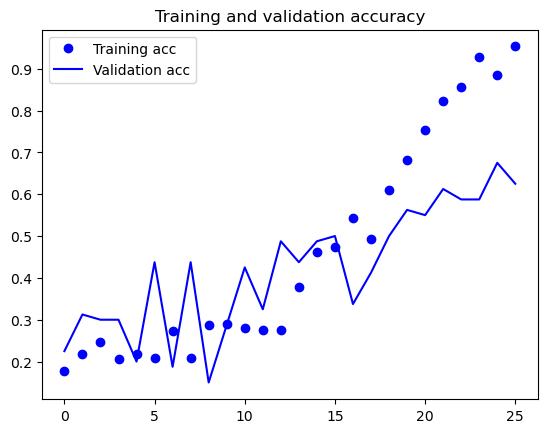

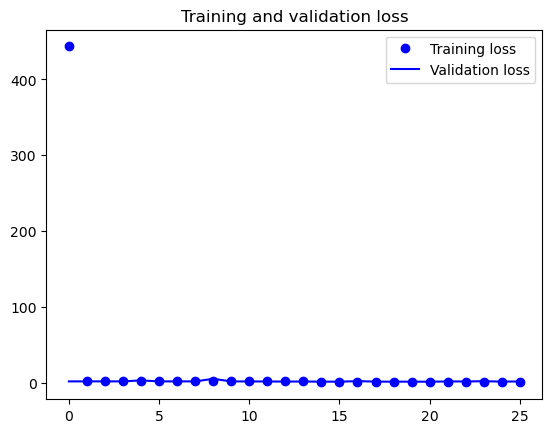

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [107]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(300, 300, 3)
)

In [108]:
for layer in base_model.layers[:15]:  # Freeze layers up to block4
    layer.trainable = False

In [109]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [111]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [112]:
# x = layers.Flatten()(base_model.output)
# x = layers.Dense(128, activation='relu')(x)  # Add a dense layer with 128 units (you can adjust as needed)
# output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
# model = models.Model(inputs=base_model.input, outputs=output) # Create the model

In [113]:
model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 41472)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               10617088  
                                                                 
 dense_15 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 25333061 (96.64 MB)
Trainable params: 17697797 (67.51 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [115]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [116]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
16/16 [==============================] - 86s 5s/step - loss: 473.8149 - accuracy: 0.1813 - val_loss: 1.6089 - val_accuracy: 0.3000
Epoch 2/100
16/16 [==============================] - 89s 6s/step - loss: 1.6100 - accuracy: 0.1750 - val_loss: 1.6088 - val_accuracy: 0.3000
Epoch 3/100
16/16 [==============================] - 90s 6s/step - loss: 1.6093 - accuracy: 0.1844 - val_loss: 1.6085 - val_accuracy: 0.2000
Epoch 4/100
16/16 [==============================] - 90s 6s/step - loss: 1.6091 - accuracy: 0.2188 - val_loss: 1.6081 - val_accuracy: 0.2000
Epoch 5/100
16/16 [==============================] - 89s 6s/step - loss: 1.6090 - accuracy: 0.1875 - val_loss: 1.6078 - val_accuracy: 0.2000
Epoch 6/100
16/16 [==============================] - 90s 6s/step - loss: 1.6087 - accuracy: 0.2188 - val_loss: 1.6074 - val_accuracy: 0.2000
Epoch 7/100
16/16 [==============================] - 89s 6s/step - loss: 1.6085 - accuracy: 0.2094 - val_loss: 1.6072 - val_accuracy: 0.2000
Epoch 8/100

In [117]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

4/4 [==============================] - 16s 4s/step - loss: 1.6239 - accuracy: 0.1400


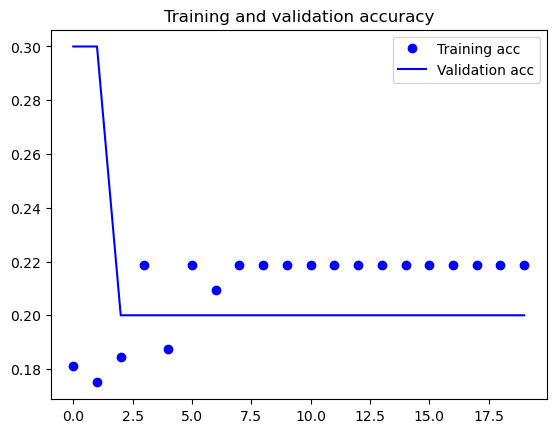

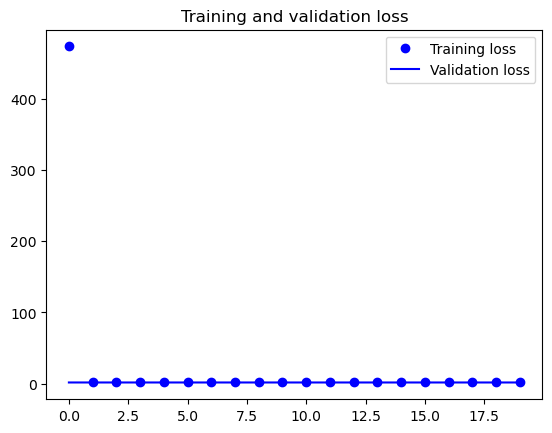

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [119]:
model.save("grapevine-leaves_VGG_model.h5")

C:\Users\MBR\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Data Augmentation

In [129]:
# original_dataset_folder = "dataset/Grapevine_Leaves_Image_Dataset"
# augmented_dataset_folder = "dataset/Augmented_Grapevine_Leaves"
# os.makedirs(augmented_dataset_folder, exist_ok=True)

In [124]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2)
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255) # for validation data

In [137]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,   
)

validation_generator = test_datagen.flow(
    X_val,
    y_val,
    batch_size=20,
    shuffle=True,
)

In [132]:
model_vgg = tf.keras.models.load_model('grapevine-leaves_VGG_model.h5')
model_archtecture = tf.keras.models.load_model('grapevine-leaves_model.h5')

In [138]:
model_archtecture.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)      

In [144]:
BATCH_SIZE = 32
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [145]:
history = model_archtecture.fit_generator(
    train_generator,
#     steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
#     validation_steps=len(X_val) // BATCH_SIZE,
    callbacks=[early_stopping]
)

C:\Users\MBR\AppData\Local\Temp\ipykernel_32744\1719877964.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_archtecture.fit_generator(


Epoch 1/100
16/16 [==============================] - 21s 1s/step - loss: 1.5604 - accuracy: 0.3000 - val_loss: 1.4307 - val_accuracy: 0.4625
Epoch 2/100
16/16 [==============================] - 28s 2s/step - loss: 1.5519 - accuracy: 0.2844 - val_loss: 1.3566 - val_accuracy: 0.4125
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 1.5477 - accuracy: 0.3187 - val_loss: 1.3918 - val_accuracy: 0.4125
Epoch 4/100
16/16 [==============================] - 25s 2s/step - loss: 1.5301 - accuracy: 0.2906 - val_loss: 1.3466 - val_accuracy: 0.4500
Epoch 5/100
16/16 [==============================] - 26s 2s/step - loss: 1.5363 - accuracy: 0.3031 - val_loss: 1.3523 - val_accuracy: 0.4500
Epoch 6/100
16/16 [==============================] - 26s 2s/step - loss: 1.5232 - accuracy: 0.3000 - val_loss: 1.3630 - val_accuracy: 0.4000
Epoch 7/100
16/16 [==============================] - 26s 2s/step - loss: 1.4928 - accuracy: 0.3187 - val_loss: 1.4022 - val_accuracy: 0.5000
Epoch 8/100
1

In [146]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_archtecture.evaluate(X_test, y_test)

4/4 [==============================] - 1s 333ms/step - loss: 111.4530 - accuracy: 0.4600


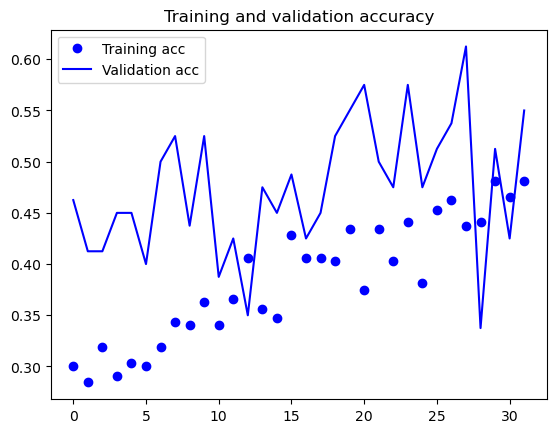

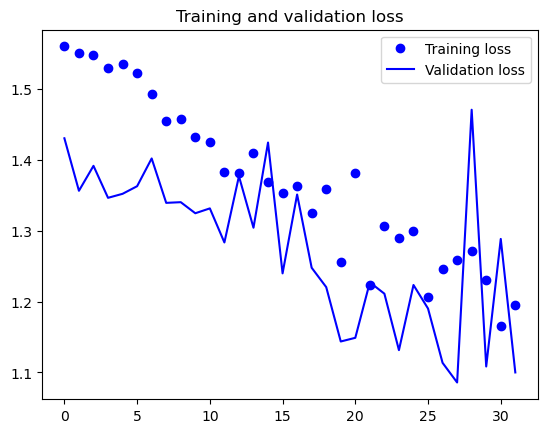

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [149]:
model_vgg.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 41472)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               10617088  
                                                                 
 dense_15 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 25333061 (96.64 MB)
Trainable params: 17697797 (67.51 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [150]:
history = model_vgg.fit_generator(
    train_generator,
#     steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
#     validation_steps=len(X_val) // BATCH_SIZE,
    callbacks=[early_stopping]
)

C:\Users\MBR\AppData\Local\Temp\ipykernel_32744\4218345284.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_vgg.fit_generator(


Epoch 1/100
16/16 [==============================] - 87s 6s/step - loss: 1.6084 - accuracy: 0.2188 - val_loss: 1.6065 - val_accuracy: 0.2000
Epoch 2/100
16/16 [==============================] - 93s 6s/step - loss: 1.6081 - accuracy: 0.2188 - val_loss: 1.6064 - val_accuracy: 0.2000
Epoch 3/100
16/16 [==============================] - 93s 6s/step - loss: 1.6081 - accuracy: 0.2188 - val_loss: 1.6065 - val_accuracy: 0.2000
Epoch 4/100
16/16 [==============================] - 92s 6s/step - loss: 1.6080 - accuracy: 0.2188 - val_loss: 1.6065 - val_accuracy: 0.2000
Epoch 5/100
16/16 [==============================] - 92s 6s/step - loss: 1.6079 - accuracy: 0.2188 - val_loss: 1.6065 - val_accuracy: 0.2000
Epoch 6/100
16/16 [==============================] - 92s 6s/step - loss: 1.6080 - accuracy: 0.2188 - val_loss: 1.6064 - val_accuracy: 0.2000


In [151]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_archtecture.evaluate(X_test, y_test)

4/4 [==============================] - 1s 330ms/step - loss: 111.4530 - accuracy: 0.4600


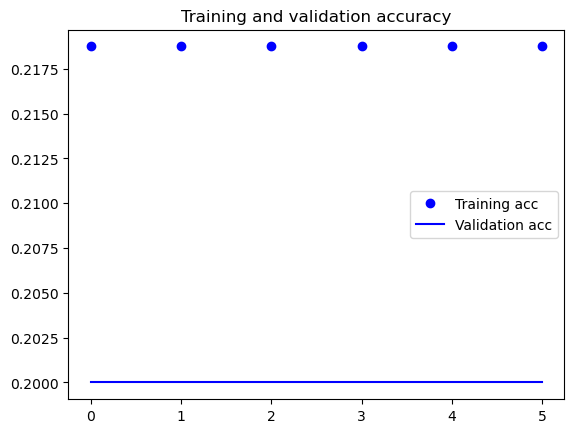

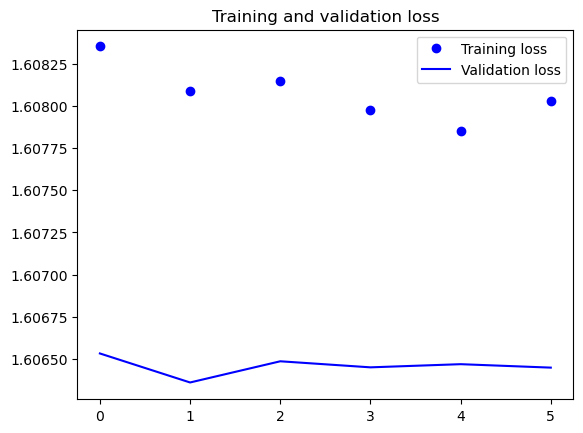

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()